# 📘 **Feature Engineering with DIPY**  
*From Raw dMRI to ML-Ready Features – Before Machine Learning*
 
> **Goal**: Understand how to preprocess diffusion MRI and extract meaningful structural features  
> **Dataset**: Stanford HARDI (`fetch_stanford_hardi`)  
> **Tools**: DIPY, NumPy, NiBabel, Matplotlib  
> **Prerequisite**: Basic Python; no ML yet!

## 📥 1. Load the Data

In [1]:
import numpy as np
from dipy.data import fetch_stanford_hardi, read_stanford_hardi
from dipy.core.gradients import gradient_table
import nibabel as nib

# Fetch and load
fetch_stanford_hardi()
hardi_img, gtab = read_stanford_hardi()
data = hardi_img.get_fdata()
affine = hardi_img.affine

print(f"✅ Data shape: {data.shape}")          # (81, 106, 76, 160)
print(f"✅ b-values: {np.unique(gtab.bvals)}") # [0. 2000.]

✅ Data shape: (81, 106, 76, 160)
✅ b-values: [   0. 2000.]


> 💡 **Teaching Note**:  
> This dataset contains **160 volumes**: 10 with no diffusion weighting (b=0) and 150 with strong diffusion weighting (b=2000 s/mm²). High b-value improves angular resolution—essential for tracking complex fiber crossings.

## 🧹 2. Preprocessing

### 2.1 Denoising with Patch2Self

In [2]:
from dipy.denoise.patch2self import patch2self
denoised_data = patch2self(data, gtab.bvals, model='ols')

### 2.2 Brain Extraction (Masking)

In [3]:
from dipy.segment.mask import median_otsu

# Use b=0 volumes for masking
b0 = denoised_data[..., gtab.b0s_mask]
b0_masked, brain_mask = median_otsu(b0, vol_idx=[0], median_radius=4, numpass=4)

### 2.3 Apply Mask

In [4]:
masked_data = denoised_data * brain_mask[..., np.newaxis]

> 💡 **Teaching Note**:  
> Why denoise first? Noise can create false fiber orientations. `Patch2Self` is **self-supervised**—it doesn’t need clean data to learn, making it ideal for real-world scans.

### ✏️ **Exercise 1**: Visualize the effect of denoising  
**Task**: Plot a b=0 slice before and after denoising using `matplotlib`.  
**Hint**: Use `data[:, :, 38, 0]` and `denoised_data[:, :, 38, 0]`.

<details>
<summary>✅ <b>Model Answer</b></summary>

```python
import matplotlib.pyplot as plt

slice_idx = 38
raw_b0 = data[:, :, slice_idx, 0]
denoised_b0 = denoised_data[:, :, slice_idx, 0]

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(raw_b0.T, origin='lower', cmap='gray')
plt.title('Raw b=0')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(denoised_b0.T, origin='lower', cmap='gray')
plt.title('Denoised b=0')
plt.axis('off')
plt.show()
```
</details>

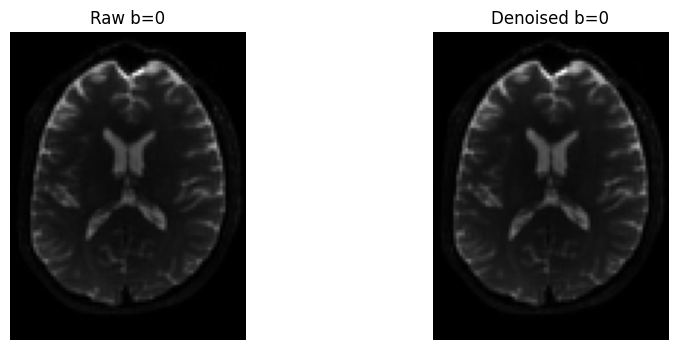

In [5]:
import matplotlib.pyplot as plt

slice_idx = 38
raw_b0 = data[:, :, slice_idx, 0]
denoised_b0 = denoised_data[:, :, slice_idx, 0]

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(raw_b0.T, origin='lower', cmap='gray')
plt.title('Raw b=0')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(denoised_b0.T, origin='lower', cmap='gray')
plt.title('Denoised b=0')
plt.axis('off')
plt.show()

## 🧬 3. Reconstruction: CSD

In [6]:
from dipy.reconst.csdeconv import auto_response_ssst, ConstrainedSphericalDeconvModel
from dipy.reconst.dti import TensorModel, fractional_anisotropy

# Response function
response, ratio = auto_response_ssst(gtab, masked_data, roi_radii=10, fa_thr=0.7)

# CSD model
csd_model = ConstrainedSphericalDeconvModel(gtab, response)
csd_fit = csd_model.fit(masked_data, mask=brain_mask)

# FA map (for stopping criterion)
dti_model = TensorModel(gtab)
dti_fit = dti_model.fit(masked_data, mask=brain_mask)
FA = fractional_anisotropy(dti_fit.evals)
FA[np.isnan(FA)] = 0

> 💡 **Teaching Note**:  
> CSD estimates the **Fiber Orientation Distribution (FOD)**—a more accurate representation than DTI in regions with crossing fibers (e.g., centrum semiovale).

## 🧵 4. Whole-Brain Tractography

In [7]:
from dipy.tracking.local_tracking import LocalTracking
from dipy.tracking.stopping_criterion import ThresholdStoppingCriterion
from dipy.data import get_sphere
from dipy.tracking.utils import random_seeds_from_mask
from dipy.direction import ProbabilisticDirectionGetter
from dipy.tracking.streamline import Streamlines

# Get sphere with keyword argument (required in DIPY >=2.0)
sphere = get_sphere(name='repulsion724')

# Create direction getter using shm_coeff (not sh_coeff)
prob_dg = ProbabilisticDirectionGetter.from_shcoeff(
    csd_fit.shm_coeff,
    max_angle=30.0,
    sphere=sphere
)

# Stopping criterion based on FA map
stopping_criterion = ThresholdStoppingCriterion(FA, threshold=0.2)

# Generate seeds — affine is now required
seeds = random_seeds_from_mask(
    brain_mask,
    affine=affine,
    seeds_count=5000,
    seed_count_per_voxel=False
)

# Perform local tracking
streamlines = Streamlines(LocalTracking(
    direction_getter=prob_dg,
    stopping_criterion=stopping_criterion,
    seeds=seeds,
    affine=affine,
    step_size=0.5
))

print(f"✅ Generated {len(streamlines)} streamlines")

✅ Generated 15157 streamlines


> 💡 **Teaching Note**:  
> Tractography is **not ground truth**—it’s a model-based reconstruction. The stopping criterion prevents tracking in isotropic areas (e.g., CSF), where FA is low.

### ❓ **Assessment Question 1**  
> **Why do we use FA as a stopping criterion, but not for direction estimation?**

<details>
<summary>✅ <b>Answer</b></summary>

FA measures **anisotropy** (how directional diffusion is), but **not orientation**.  
- Direction comes from CSD’s FOD (which resolves crossings).  
- FA just tells us: “Is this voxel likely white matter?” → if FA < 0.2, stop tracking.  
Using FA alone for direction would fail in crossing regions (DTI’s main flaw).
</details>

## 📊 5. Tractometry: Feature Extraction

### Extract Corpus Callosum (CC)

In [8]:
from dipy.tracking.streamline import select_by_rois

mid_x = data.shape[0] // 2
mid_z = data.shape[2] // 2

roi_cc = np.zeros_like(brain_mask)
roi_cc[mid_x - 2:mid_x + 3, :, mid_z - 5:mid_z + 5] = 1

# Keep streamlines that pass through this midline ROI
cc_streamlines = list(select_by_rois(
    streamlines=streamlines,
    rois=[roi_cc],
    include=[True],
    affine=affine,
    tol=2,
    mode='any'
))

print(f"✅ CC-like bundle: {len(cc_streamlines)} streamlines")

✅ CC-like bundle: 1028 streamlines


### Compute FA Profile

In [9]:
# Remove streamlines with fewer than 2 points
cc_streamlines_clean = [s for s in cc_streamlines if len(s) >= 2]

if len(cc_streamlines_clean) > 0:
    from dipy.stats.analysis import afq_profile
    cc_fa_profile = afq_profile(FA, cc_streamlines_clean, affine)
    cc_mean_fa = np.nanmean(cc_fa_profile)
    print(f"✅ Mean FA in CC: {cc_mean_fa:.3f}")
else:
    cc_mean_fa = np.nan
    print("⚠️ No valid streamlines (with ≥2 points) in CC bundle.")

✅ Mean FA in CC: 0.480


> 💡 **Teaching Note**:  
> This scalar (`cc_mean_fa`) is now a **feature**—just like a column in a spreadsheet. In a real study, you’d compute this for 100 subjects → build a dataset → train an ML model.

### ✏️ **Exercise 2**: Extract the Corticospinal Tract (CST)  
**Task**: Create an ROI in the **postcentral gyrus** (motor cortex) and **pons** to isolate CST.  
- Motor cortex ≈ x: 25–35, y: 40–50, z: 50–60  
- Pons ≈ x: 35–45, y: 30–40, z: 20–30  

**Goal**: Get a CST-like bundle and compute its mean FA.

<details>
<summary>✅ <b>Model Answer</b></summary>

```python
# Define ROIs
roi_motor = np.zeros_like(brain_mask)
roi_motor[25:36, 40:51, 50:61] = 1

roi_pons = np.zeros_like(brain_mask)
roi_pons[35:46, 30:41, 20:31] = 1

# Select streamlines passing through BOTH
cst_streamlines = select_by_rois(
    streamlines, [roi_motor, roi_pons], affine=affine, tol=2, mode='both_endpoints'
)

print(f"CST-like streamlines: {len(cst_streamlines)}")

if len(cst_streamlines) > 0:
    cst_fa = afq_profile(FA, cst_streamlines, affine)
    print(f"Mean FA in CST: {np.nanmean(cst_fa):.3f}")
```
> 📝 **Note**: This is a rough approximation. Real CST segmentation uses waypoint ROIs or atlas registration (e.g., via `dipy.segment.bundles.RecoBundles`).
</details>

In [12]:
from dipy.tracking.streamline import select_by_rois

# Define ROIs
roi_motor = np.zeros_like(brain_mask)
roi_motor[25:36, 40:51, 50:61] = 1

roi_pons = np.zeros_like(brain_mask)
roi_pons[35:46, 30:41, 20:31] = 1

# Select streamlines with one endpoint in each ROI
cst_streamlines = list(select_by_rois(
    streamlines=streamlines,
    rois=[roi_motor, roi_pons],
    include=[True, True],
    affine=affine,
    tol=2,
    mode='both_end'  # ← corrected mode name
))

print(f"CST-like streamlines: {len(cst_streamlines)}")

# Clean: remove degenerate streamlines (<2 points)
cst_streamlines = [s for s in cst_streamlines if len(s) >= 2]

if len(cst_streamlines) > 0:
    from dipy.stats.analysis import afq_profile
    cst_fa = afq_profile(FA, cst_streamlines, affine=affine)
    print(f"Mean FA in CST: {np.nanmean(cst_fa):.3f}")
else:
    print("⚠️ No valid CST streamlines found.")

CST-like streamlines: 147
Mean FA in CST: 0.290


## 📝  6. Summary & Bridge to ML

We now have:
- A **preprocessing pipeline**
- A method to **generate streamlines**
- A way to **extract bundles** and compute **scalar features** (e.g., `cc_mean_fa`, `cst_mean_fa`)

➡️ In ML, you’d repeat this for **many subjects** → build a feature matrix → predict diagnosis, age, cognition, etc.

### ❓ **Assessment Question 2**  
> **Why can’t we feed raw dMRI data directly into a standard ML model (like XGBoost)?**

<details>
<summary>✅ <b>Answer</b></summary>

Raw dMRI is **4D** (x, y, z, directions) and **high-dimensional** (~1.5M voxels × 160 volumes).  
- XGBoost expects **2D tabular data** (samples × features).  
- Most voxels are irrelevant (e.g., skull, CSF).  
- Features must be **biologically meaningful** (e.g., white matter integrity), not raw intensity.  
→ Hence, we **engineer features** via tractometry.
</details>

## 💾 7. Save Features to CSV (ML Dataset)

In [20]:
# --- Prepare dataframe ---
import pandas as pd
import numpy as np
from dipy.tracking.utils import length
from dipy.stats.analysis import afq_profile

# --- Compute additional real features (lengths, GFA, centroids) ---
# CC
cc_lengths = np.array(list(length(cc_streamlines_clean)))
cc_gfa_profile = afq_profile(csd_fit.gfa, cc_streamlines_clean, affine)

# CST
cst_lengths = np.array(list(length(cst_streamlines)))
cst_gfa_profile = afq_profile(csd_fit.gfa, cst_streamlines, affine)

# Centroids
cc_points = np.vstack(cc_streamlines_clean)
cst_points = np.vstack(cst_streamlines)
cc_centroid = np.mean(cc_points, axis=0)
cst_centroid = np.mean(cst_points, axis=0)

# White matter mask for global metrics
wm_mask = brain_mask & (FA > 0.2)

# Assemble real, computed features (no NaNs)
features = {
    "subject_id": "001",
    
    # CC features
    "cc_mean_fa": float(np.nanmean(cc_fa_profile)),
    "cc_mean_gfa": float(np.nanmean(cc_gfa_profile)),
    "cc_mean_length_mm": float(np.mean(cc_lengths)),
    "cc_std_length_mm": float(np.std(cc_lengths)),
    "cc_n_streamlines": len(cc_streamlines_clean),
    "cc_centroid_x": float(cc_centroid[0]),
    "cc_centroid_y": float(cc_centroid[1]),
    "cc_centroid_z": float(cc_centroid[2]),
    
    # CST features
    "cst_mean_fa": float(np.nanmean(cst_fa)),
    "cst_mean_gfa": float(np.nanmean(cst_gfa_profile)),
    "cst_mean_length_mm": float(np.mean(cst_lengths)),
    "cst_std_length_mm": float(np.std(cst_lengths)),
    "cst_n_streamlines": len(cst_streamlines),
    "cst_centroid_x": float(cst_centroid[0]),
    "cst_centroid_y": float(cst_centroid[1]),
    "cst_centroid_z": float(cst_centroid[2]),
    
    # Global features
    "global_mean_fa": float(np.mean(FA[wm_mask])),
    "global_mean_gfa": float(np.mean(csd_fit.gfa[wm_mask])),
    "total_streamlines": len(streamlines),
}

# Create DataFrame
df = pd.DataFrame([features])


print("="*60)
print(f"\n📊 Shape: {df.shape} (1 subject, {df.shape[1]-1} features)")

df.head()


📊 Shape: (1, 20) (1 subject, 19 features)


,subject_id,cc_mean_fa,cc_mean_gfa,cc_mean_length_mm,cc_std_length_mm,cc_n_streamlines,cc_centroid_x,cc_centroid_y,cc_centroid_z,cst_mean_fa,cst_mean_gfa,cst_mean_length_mm,cst_std_length_mm,cst_n_streamlines,cst_centroid_x,cst_centroid_y,cst_centroid_z,global_mean_fa,global_mean_gfa,total_streamlines
0,001,0.480126,0.891664,112.496172,59.137558,653,-0.471782,-14.895922,22.739354,0.289991,0.807057,19.323529,30.407014,17,-0.38084,-44.047228,-19.034848,0.407373,0.86145,15157


## 📚 References & Further Learning

- DIPY Documentation: https://dipy.org  
- DIPY Workshop 2025: https://workshop.dipy.org  
- Garyfallidis Research Group: https://grg.luddy.indiana.edu  
- Stanford HARDI Dataset: [DIPY Data](https://dipy.org/documentation/1.9.0/examples_built/data_fetcher/)

---

✅ **End of Tutorial**

